### King County House prices -- Linear Regression Analysis

In [1]:
# see the value of multiple statements at once.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:

import warnings; warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import scipy

pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x))
np.set_printoptions(suppress=True)


# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns
sns.set()



#sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_regression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn import metrics

from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV

from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RandomizedLasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor


from sklearn.svm import SVR
from sklearn.svm import LinearSVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor



/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/nbuser/anaconda3_23/lib/python3.4/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# Data Source:
# https://www.kaggle.com/harlfoxem/housesalesprediction/data

from azureml import Workspace
ws = Workspace(
    workspace_id='11e3f8021a1e4d018d29b2a147e53fe0',
    authorization_token='ba3566b6c5bf4c5ba9e5476441822d89',
    endpoint='https://studioapi.azureml.net'
)
ds = ws.datasets['kc_house_data.csv']
df = ds.to_dataframe()
df.isnull().any(axis=1)[:10]

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool

### Data exploration and Visualization

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,...,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,...,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,...,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,...,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,...,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [5]:
df.shape

(21613, 21)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [7]:
df.isnull().any(axis=1)[:10]

0    False
1    False
2    False
3    False
4    False
5    False
6    False
7    False
8    False
9    False
dtype: bool

In [8]:
# no rows has missing or na values
df[df.isnull().any(axis=1)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [9]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,4580301520.86,540088.14,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46
std,2876565571.31,367127.20,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18
min,1000102.00,75000.00,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,2123049194.00,321950.00,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3904930410.00,450000.00,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,7308900445.00,645000.00,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,9900000190.00,7700000.00,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


In [10]:
features = [x for x in df.columns if x not in ['id', 'price', 'date']]
features

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15']

In [11]:
price = df['price']
X = df[features] 
X.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


In [12]:
X.describe()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00,21613.00
mean,3.37,2.11,2079.90,15106.97,1.49,0.01,0.23,3.41,7.66,1788.39,291.51,1971.01,84.40,98077.94,47.56,-122.21,1986.55,12768.46
std,0.93,0.77,918.44,41420.51,0.54,0.09,0.77,0.65,1.18,828.09,442.58,29.37,401.68,53.51,0.14,0.14,685.39,27304.18
min,0.00,0.00,290.00,520.00,1.00,0.00,0.00,1.00,1.00,290.00,0.00,1900.00,0.00,98001.00,47.16,-122.52,399.00,651.00
25%,3.00,1.75,1427.00,5040.00,1.00,0.00,0.00,3.00,7.00,1190.00,0.00,1951.00,0.00,98033.00,47.47,-122.33,1490.00,5100.00
50%,3.00,2.25,1910.00,7618.00,1.50,0.00,0.00,3.00,7.00,1560.00,0.00,1975.00,0.00,98065.00,47.57,-122.23,1840.00,7620.00
75%,4.00,2.50,2550.00,10688.00,2.00,0.00,0.00,4.00,8.00,2210.00,560.00,1997.00,0.00,98118.00,47.68,-122.12,2360.00,10083.00
max,33.00,8.00,13540.00,1651359.00,3.50,1.00,4.00,5.00,13.00,9410.00,4820.00,2015.00,2015.00,98199.00,47.78,-121.31,6210.00,871200.00


In [13]:
pd.DataFrame(price.describe(percentiles=[.05, .25, .75, .95])).transpose()

,count,mean,std,min,5%,25%,50%,75%,95%,max
price,21613.00,540088.14,367127.20,75000.00,210000.00,321950.00,450000.00,645000.00,1156480.00,7700000.00


In [14]:
pd.DataFrame(np.log(price).describe(percentiles=[.05, .25, .75, .95])).transpose()

,count,mean,std,min,5%,25%,50%,75%,95%,max
price,21613.00,13.05,0.53,11.23,12.25,12.68,13.02,13.38,13.96,15.86


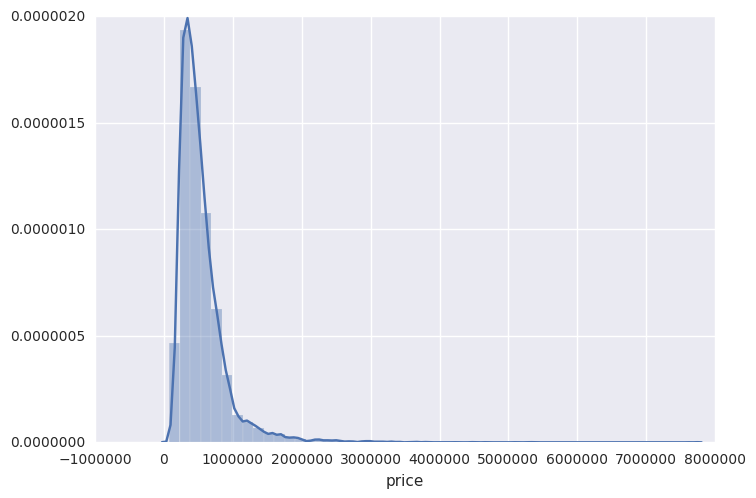

In [15]:
sns.distplot(price)
plt.show();

In [16]:
#skewness and kurtosis
price.skew()
price.kurt()

4.0240691446847121

34.585540431942427

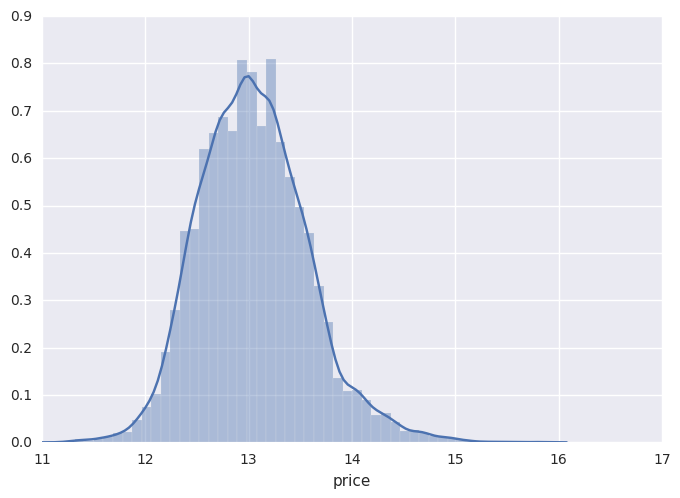

In [17]:
sns.distplot(np.log(price))
plt.show();

In [18]:
# skewness and kurtosis
np.log(price).skew() # It becomes fairly symmetrical
np.log(price).kurt()

0.42807247557592526

0.69185395283528095

In [19]:
corr_matrix = df[features + ["price"]].corr()
corr_matrix

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
bedrooms,1.00,0.52,0.58,0.03,0.18,-0.01,0.08,0.03,0.36,0.48,0.30,0.15,0.02,-0.15,-0.01,0.13,0.39,0.03,0.31
bathrooms,0.52,1.00,0.75,0.09,0.50,0.06,0.19,-0.12,0.66,0.69,0.28,0.51,0.05,-0.20,0.02,0.22,0.57,0.09,0.53
sqft_living,0.58,0.75,1.00,0.17,0.35,0.10,0.28,-0.06,0.76,0.88,0.44,0.32,0.06,-0.20,0.05,0.24,0.76,0.18,0.70
sqft_lot,0.03,0.09,0.17,1.00,-0.01,0.02,0.07,-0.01,0.11,0.18,0.02,0.05,0.01,-0.13,-0.09,0.23,0.14,0.72,0.09
floors,0.18,0.50,0.35,-0.01,1.00,0.02,0.03,-0.26,0.46,0.52,-0.25,0.49,0.01,-0.06,0.05,0.13,0.28,-0.01,0.26
waterfront,-0.01,0.06,0.10,0.02,0.02,1.00,0.40,0.02,0.08,0.07,0.08,-0.03,0.09,0.03,-0.01,-0.04,0.09,0.03,0.27
view,0.08,0.19,0.28,0.07,0.03,0.40,1.00,0.05,0.25,0.17,0.28,-0.05,0.10,0.08,0.01,-0.08,0.28,0.07,0.40
condition,0.03,-0.12,-0.06,-0.01,-0.26,0.02,0.05,1.00,-0.14,-0.16,0.17,-0.36,-0.06,0.00,-0.01,-0.11,-0.09,-0.00,0.04
grade,0.36,0.66,0.76,0.11,0.46,0.08,0.25,-0.14,1.00,0.76,0.17,0.45,0.01,-0.18,0.11,0.20,0.71,0.12,0.67
sqft_above,0.48,0.69,0.88,0.18,0.52,0.07,0.17,-0.16,0.76,1.00,-0.05,0.42,0.02,-0.26,-0.00,0.34,0.73,0.19,0.61


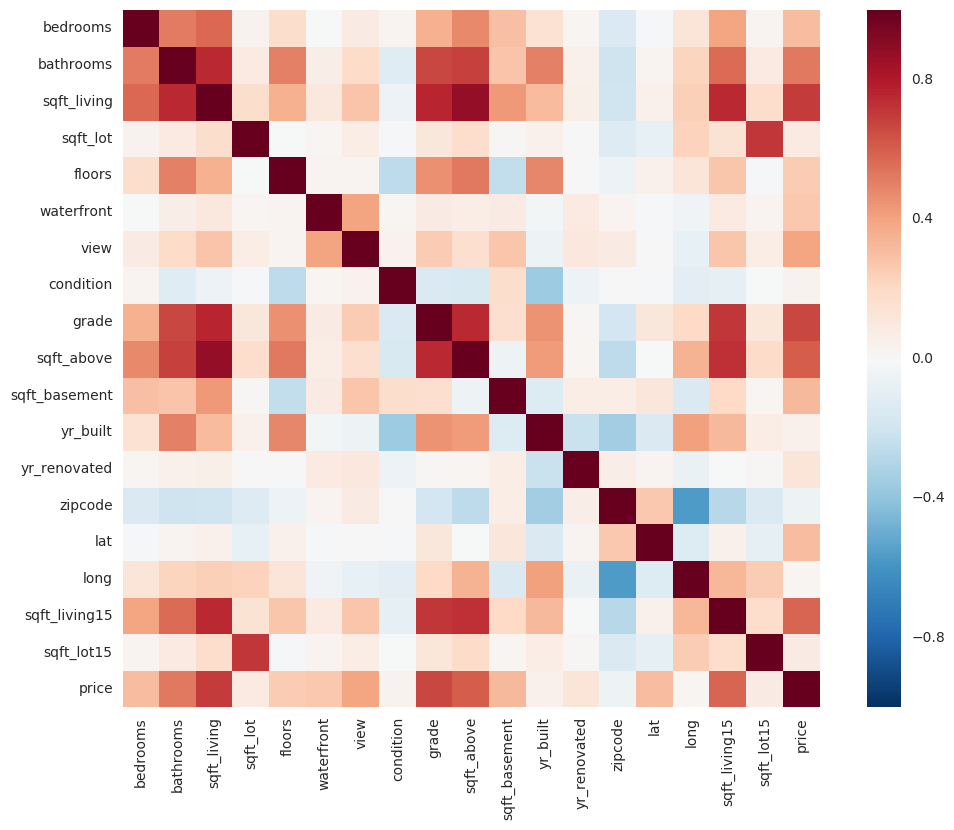

In [20]:
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_matrix, square=True)
plt.show();

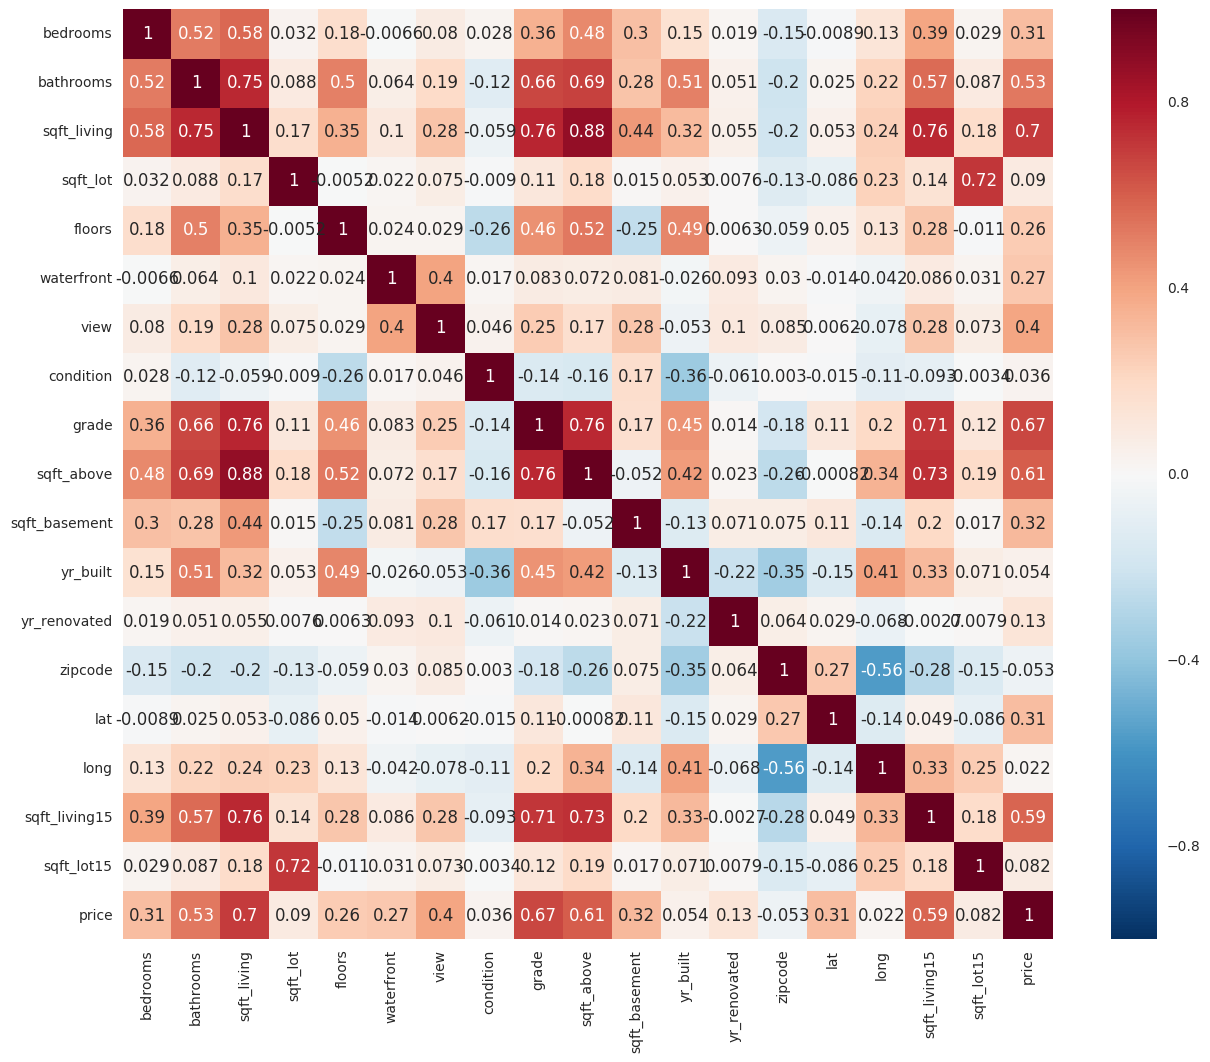

In [21]:
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt="0.2g", square=True)
plt.show();

Clearly, prices is highly correlated with bathrooms, sqft_living , grade, sqft_above, sqft_living15. However prices is very weakly correlated with sqft_lot and sqft_lot15. Also,  sqft_living is highly correlated with sqft_living15, sqft_above, grade, and bathrooms. 

In [22]:
# corr value >= 0.5
corr_more_than_point_5 = corr_matrix.where(corr_matrix >= 0.5)
corr_more_than_point_5

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
bedrooms,1.00,0.52,0.58,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bathrooms,0.52,1.00,0.75,nan,0.50,nan,nan,nan,0.66,0.69,nan,0.51,nan,nan,nan,nan,0.57,nan,0.53
sqft_living,0.58,0.75,1.00,nan,nan,nan,nan,nan,0.76,0.88,nan,nan,nan,nan,nan,nan,0.76,nan,0.70
sqft_lot,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.72,nan
floors,nan,0.50,nan,nan,1.00,nan,nan,nan,nan,0.52,nan,nan,nan,nan,nan,nan,nan,nan,nan
waterfront,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
view,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
condition,nan,nan,nan,nan,nan,nan,nan,1.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
grade,nan,0.66,0.76,nan,nan,nan,nan,nan,1.00,0.76,nan,nan,nan,nan,nan,nan,0.71,nan,0.67
sqft_above,nan,0.69,0.88,nan,0.52,nan,nan,nan,0.76,1.00,nan,nan,nan,nan,nan,nan,0.73,nan,0.61


In [23]:
corr_more_than_point_5_filtered = corr_more_than_point_5.where(((corr_more_than_point_5.notnull()) & (corr_more_than_point_5 != 1.0)))
corr_more_than_point_5_filtered
corr_more_than_point_5_filtered.isnull().all()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
bedrooms,nan,0.52,0.58,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
bathrooms,0.52,nan,0.75,nan,0.50,nan,nan,nan,0.66,0.69,nan,0.51,nan,nan,nan,nan,0.57,nan,0.53
sqft_living,0.58,0.75,nan,nan,nan,nan,nan,nan,0.76,0.88,nan,nan,nan,nan,nan,nan,0.76,nan,0.70
sqft_lot,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.72,nan
floors,nan,0.50,nan,nan,nan,nan,nan,nan,nan,0.52,nan,nan,nan,nan,nan,nan,nan,nan,nan
waterfront,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
view,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
condition,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
grade,nan,0.66,0.76,nan,nan,nan,nan,nan,nan,0.76,nan,nan,nan,nan,nan,nan,0.71,nan,0.67
sqft_above,nan,0.69,0.88,nan,0.52,nan,nan,nan,0.76,nan,nan,nan,nan,nan,nan,nan,0.73,nan,0.61


bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront        True
view              True
condition         True
grade            False
sqft_above       False
sqft_basement     True
yr_built         False
yr_renovated      True
zipcode           True
lat               True
long              True
sqft_living15    False
sqft_lot15       False
price            False
dtype: bool

In [24]:
corr_more_than_point_5_filtered_v2 = corr_more_than_point_5_filtered.drop(
        corr_more_than_point_5_filtered.columns[corr_more_than_point_5_filtered.isnull().all()], axis=1)
corr_more_than_point_5_filtered_v2

high_corr_features = corr_more_than_point_5_filtered_v2.columns
high_corr_features

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,grade,sqft_above,yr_built,sqft_living15,sqft_lot15,price
bedrooms,nan,0.52,0.58,nan,nan,nan,nan,nan,nan,nan,nan
bathrooms,0.52,nan,0.75,nan,0.50,0.66,0.69,0.51,0.57,nan,0.53
sqft_living,0.58,0.75,nan,nan,nan,0.76,0.88,nan,0.76,nan,0.70
sqft_lot,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.72,nan
floors,nan,0.50,nan,nan,nan,nan,0.52,nan,nan,nan,nan
waterfront,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
view,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
condition,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
grade,nan,0.66,0.76,nan,nan,nan,0.76,nan,0.71,nan,0.67
sqft_above,nan,0.69,0.88,nan,0.52,0.76,nan,nan,0.73,nan,0.61


Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'grade',
       'sqft_above', 'yr_built', 'sqft_living15', 'sqft_lot15', 'price'],
      dtype='object')

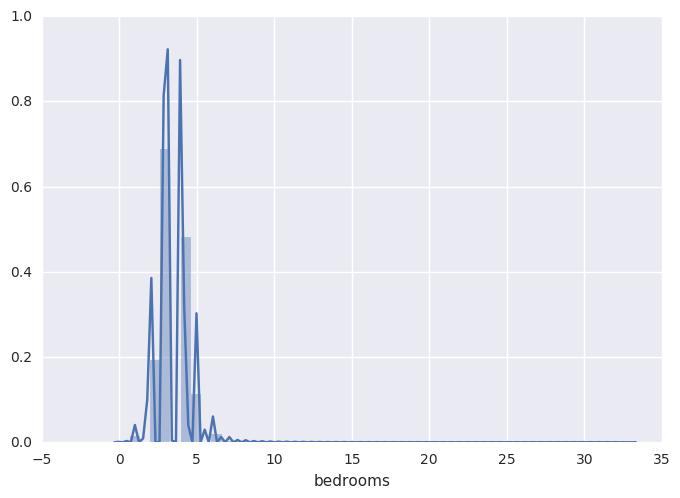

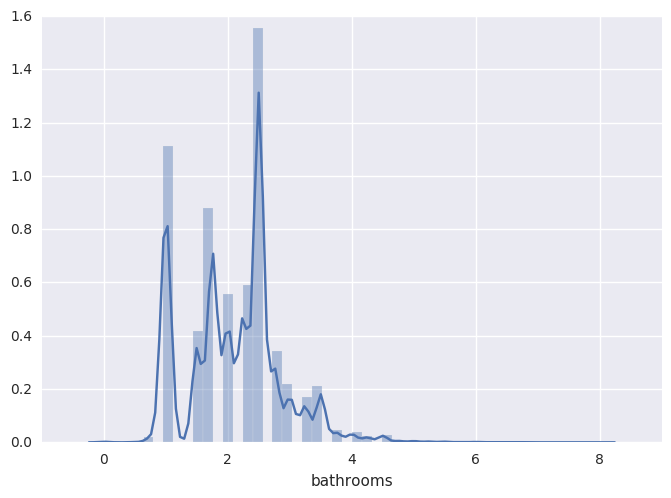

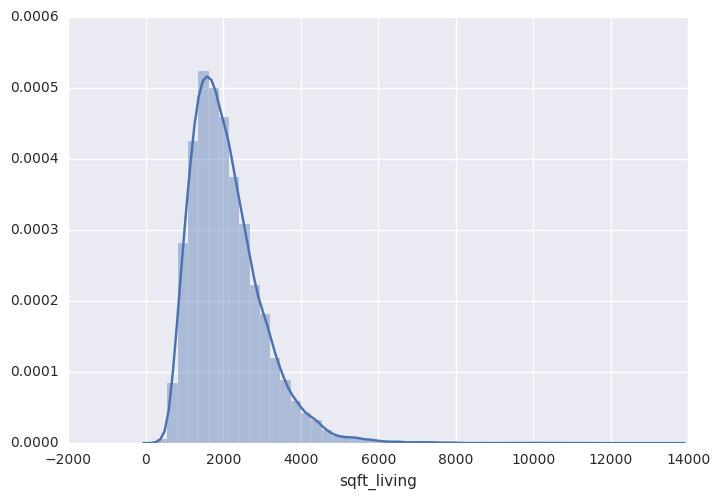

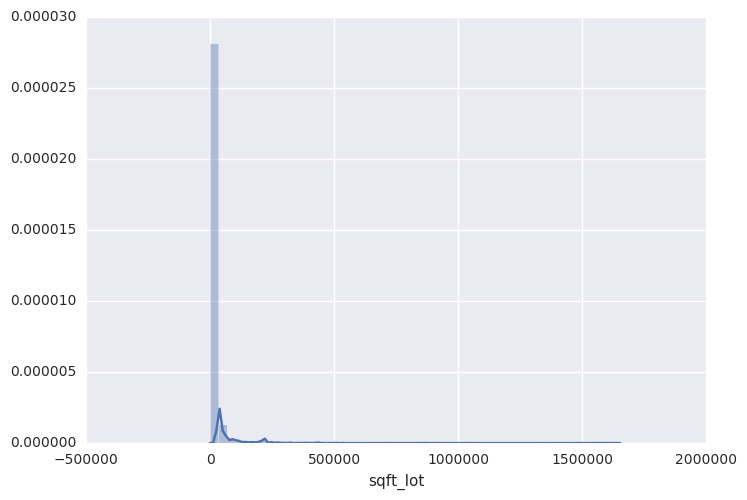

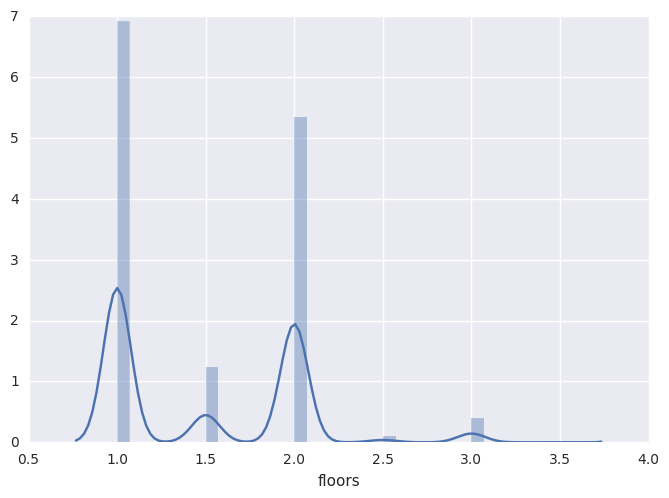

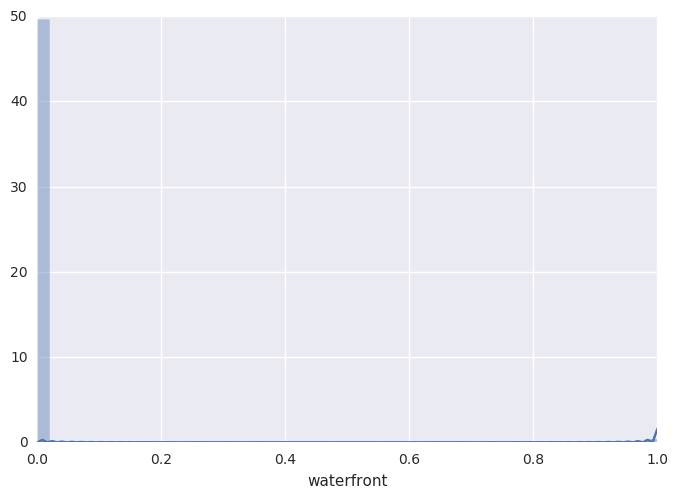

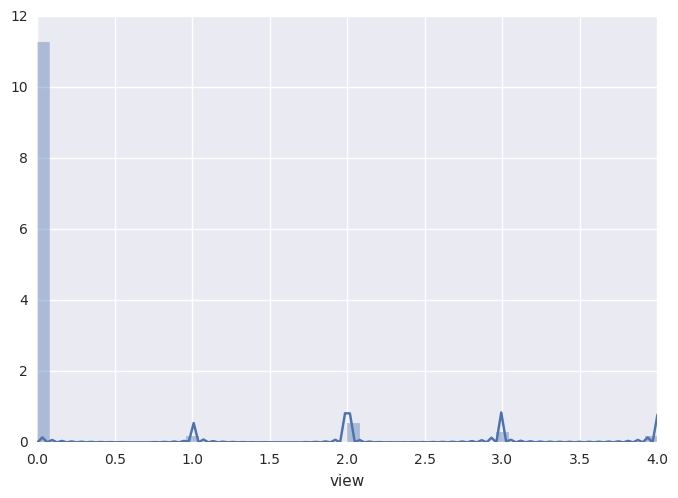

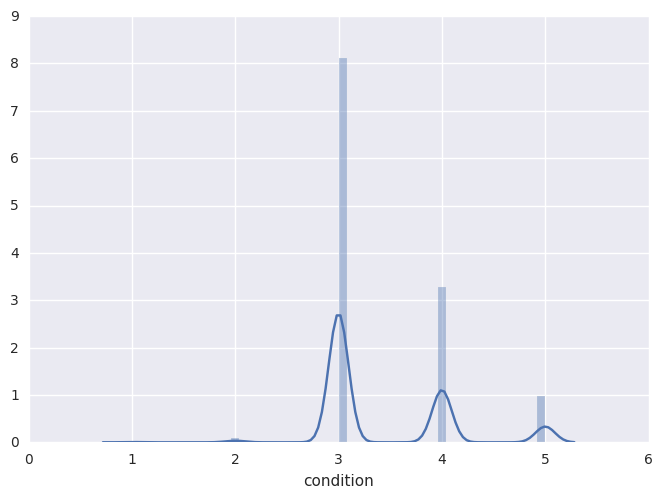

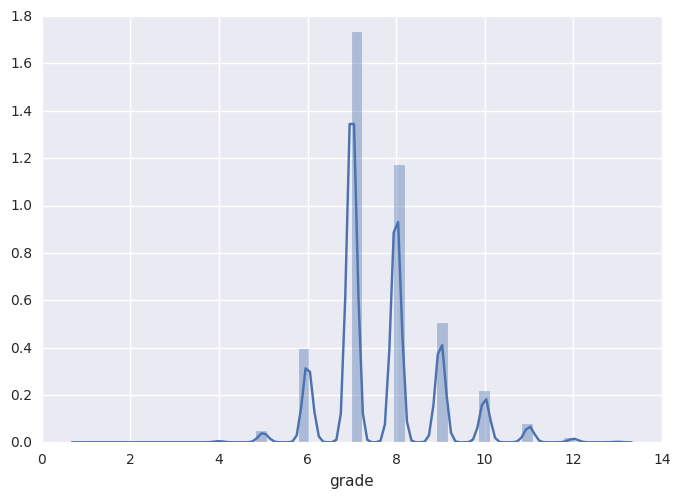

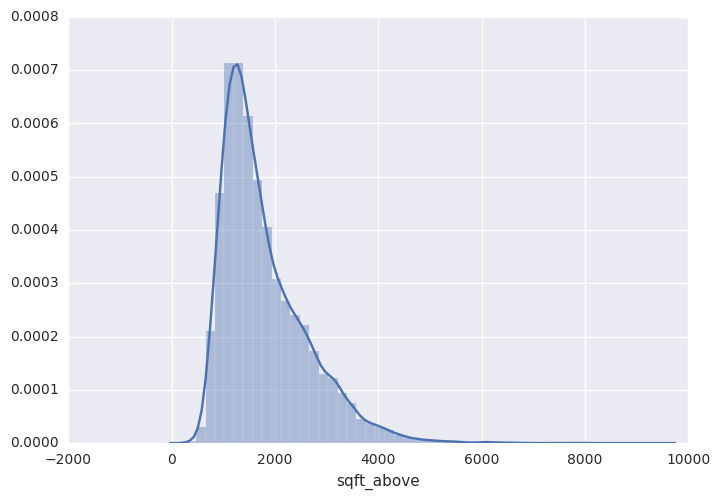

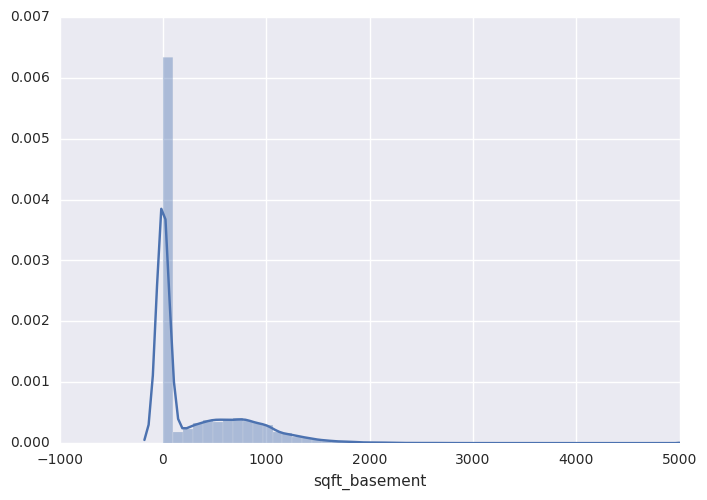

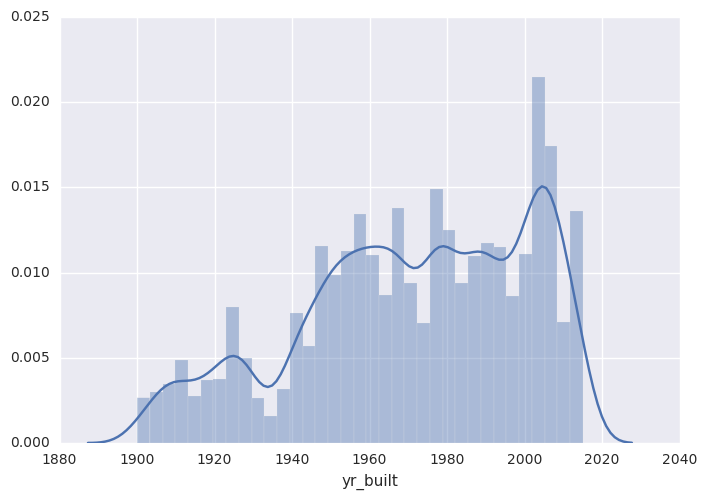

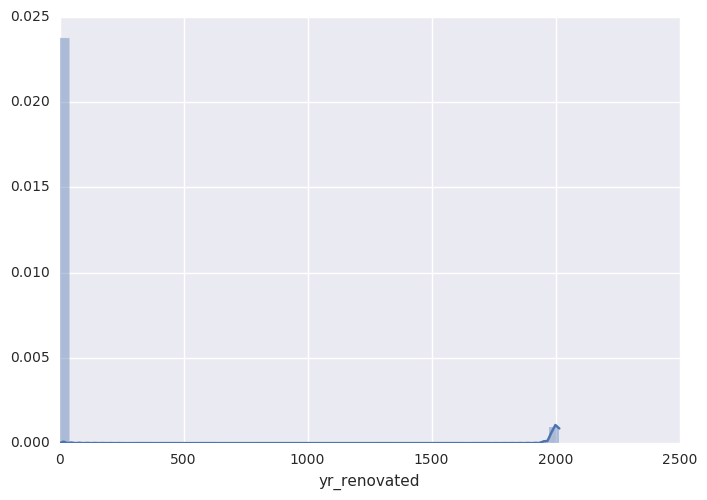

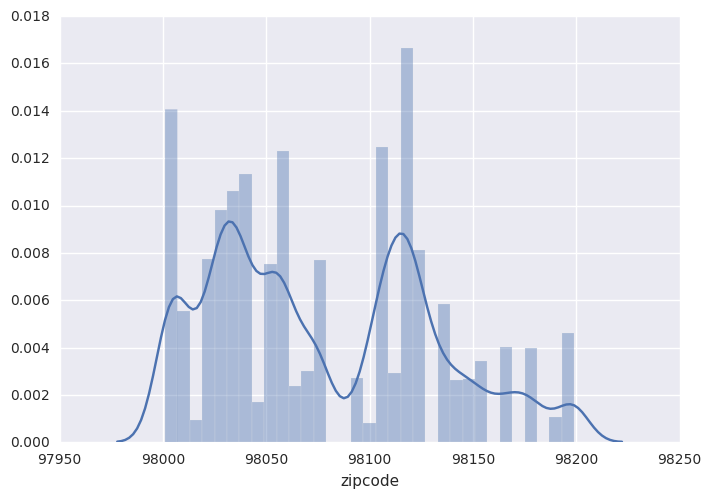

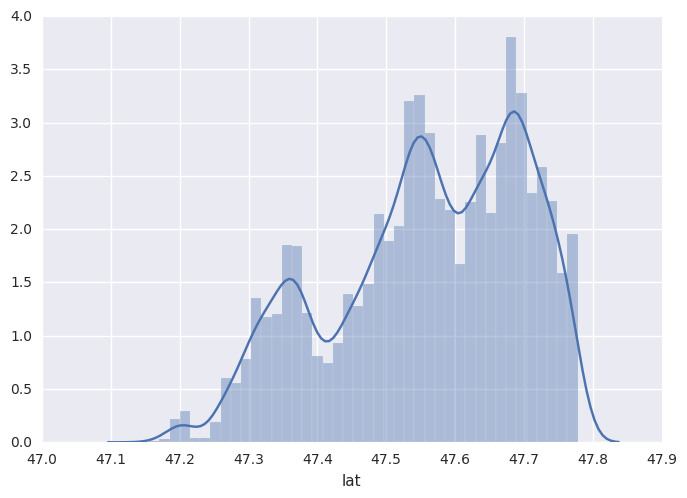

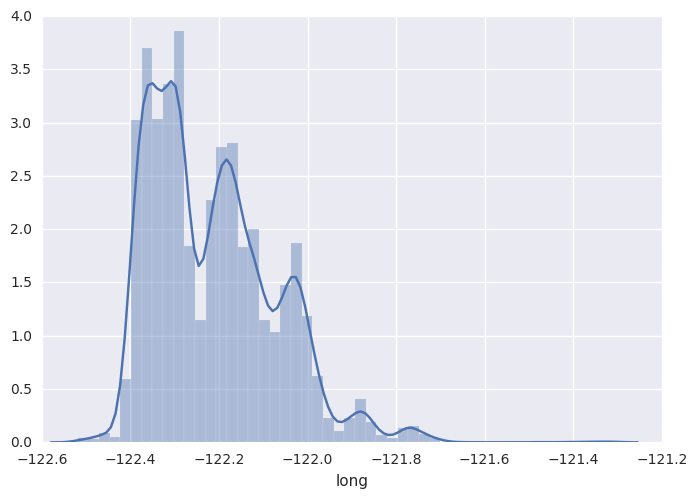

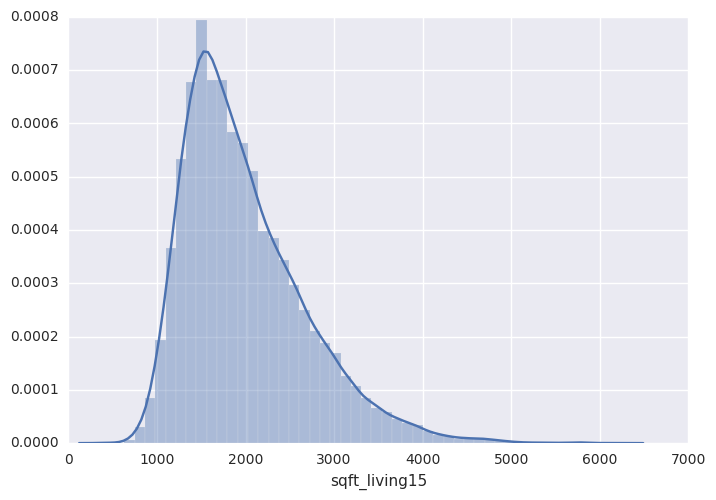

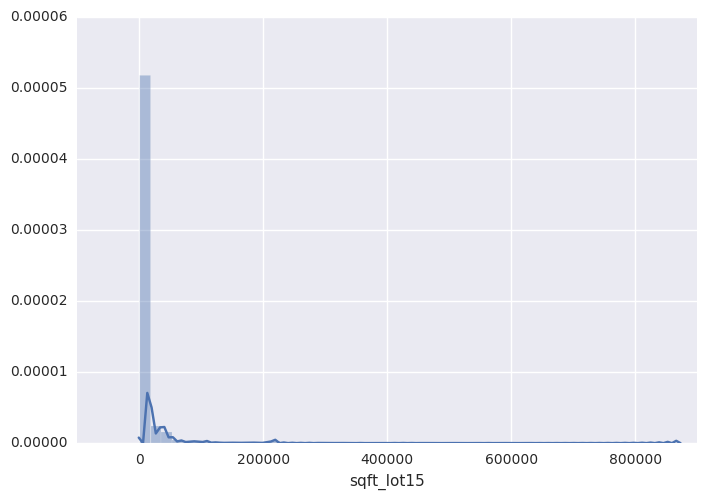

In [25]:
# distribution plot for features
for feature in features:
    sns.distplot(df[feature])
    plt.show();

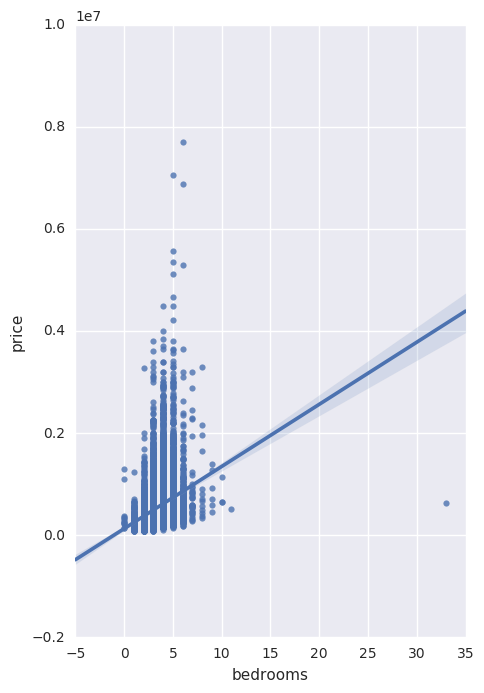

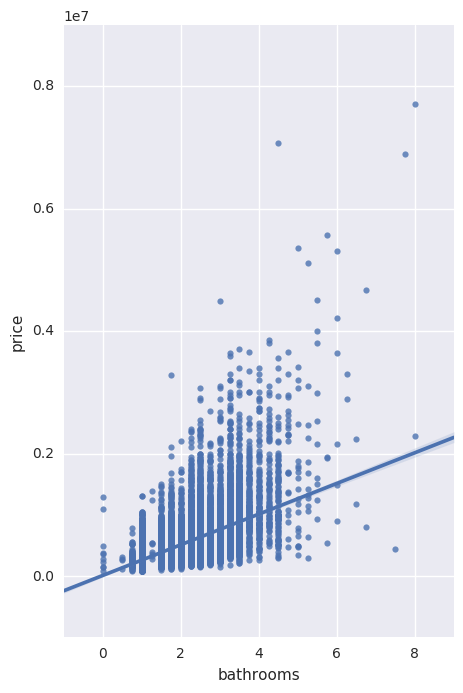

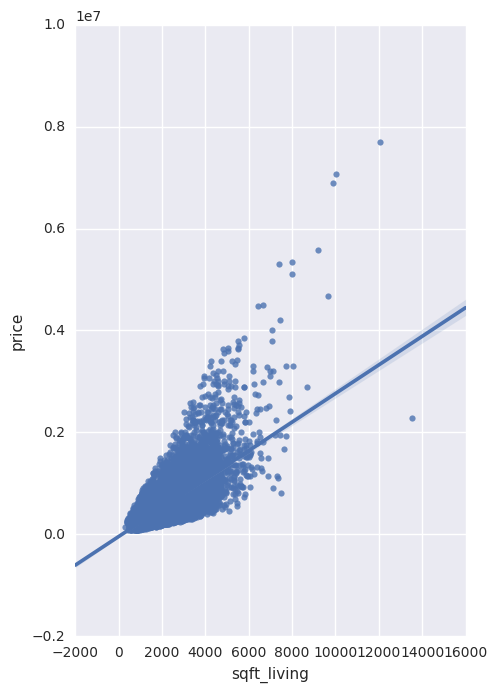

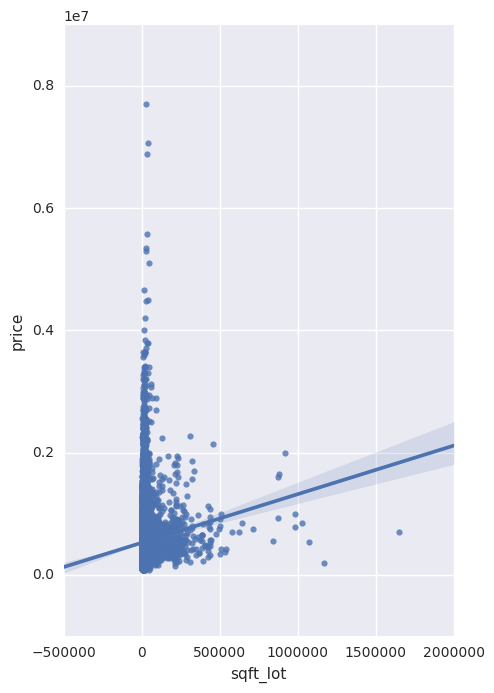

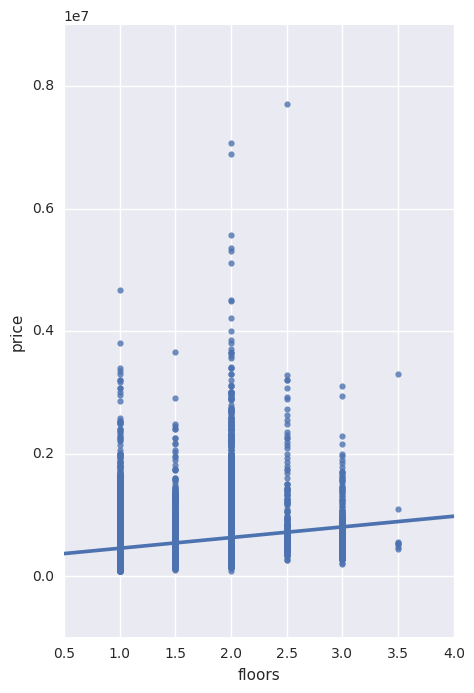

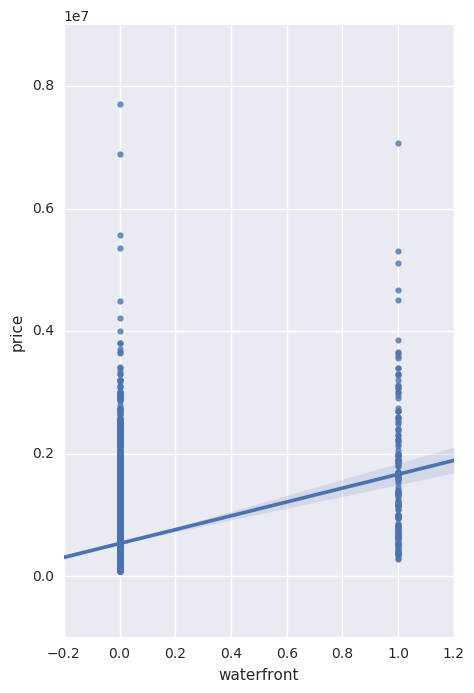

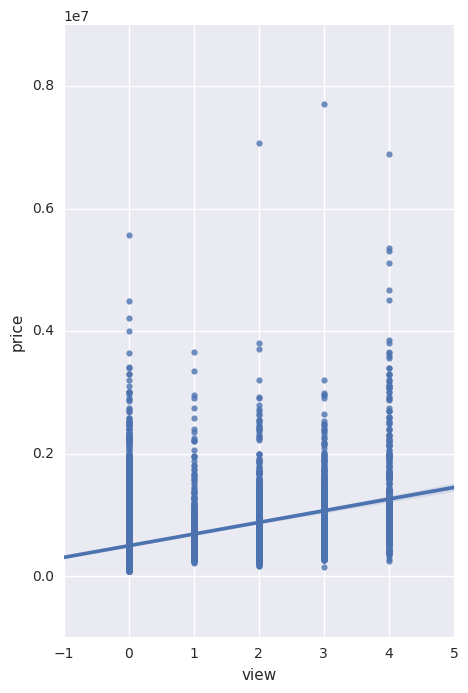

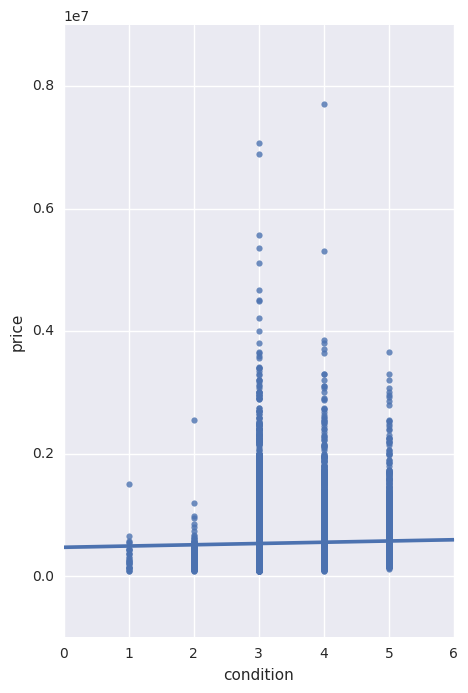

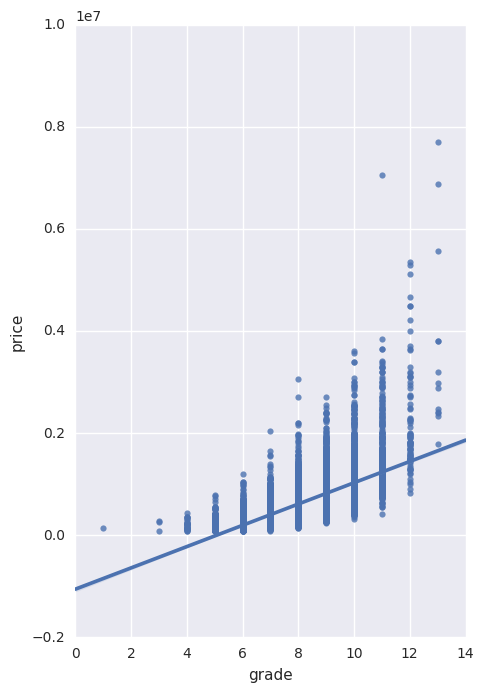

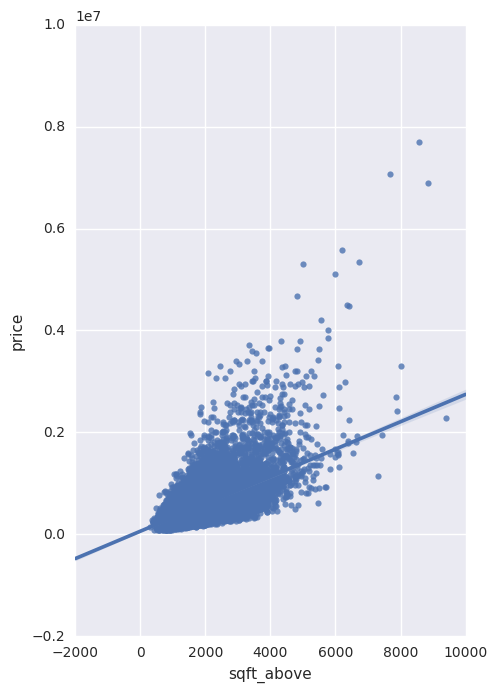

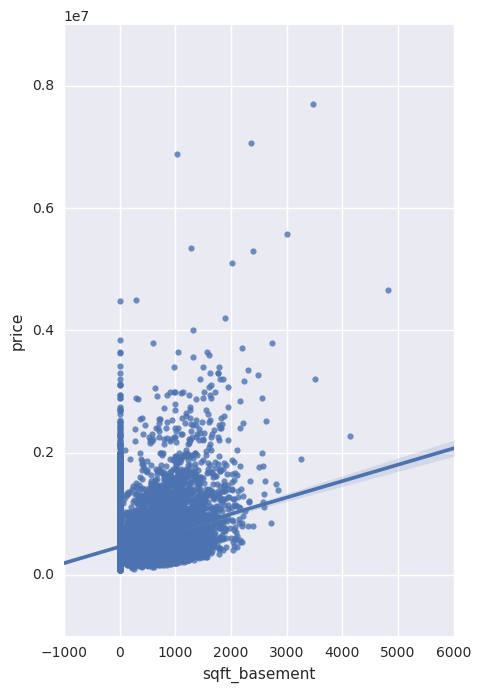

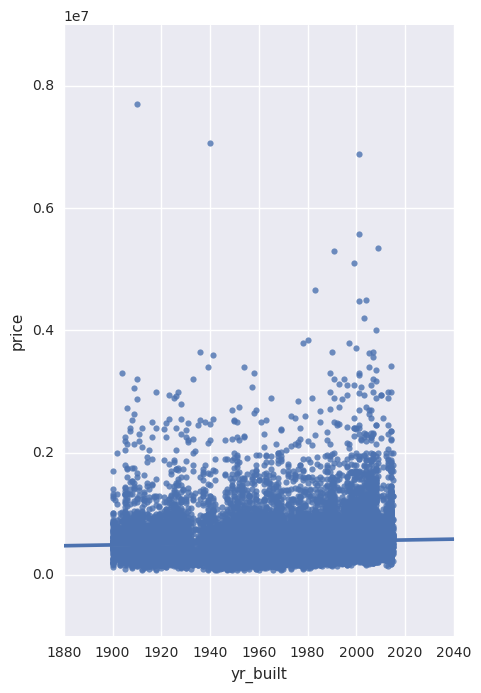

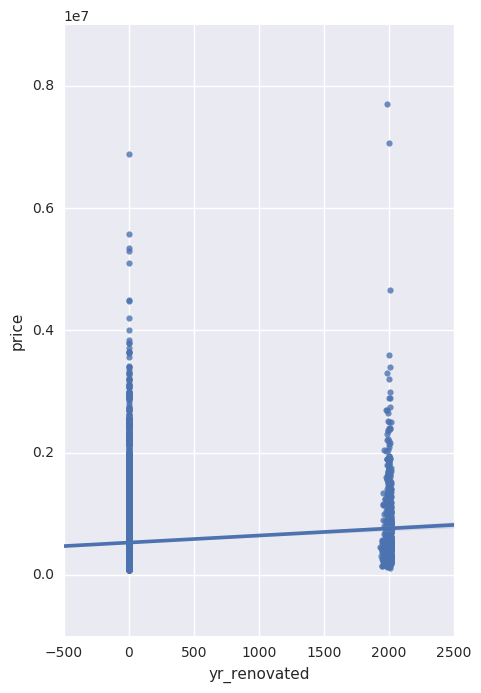

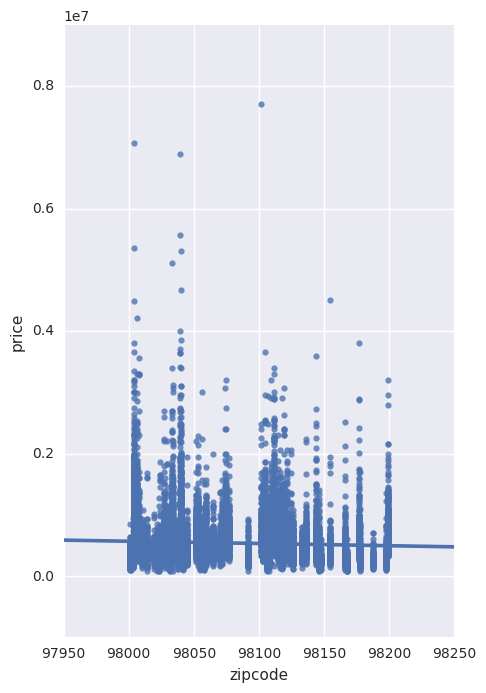

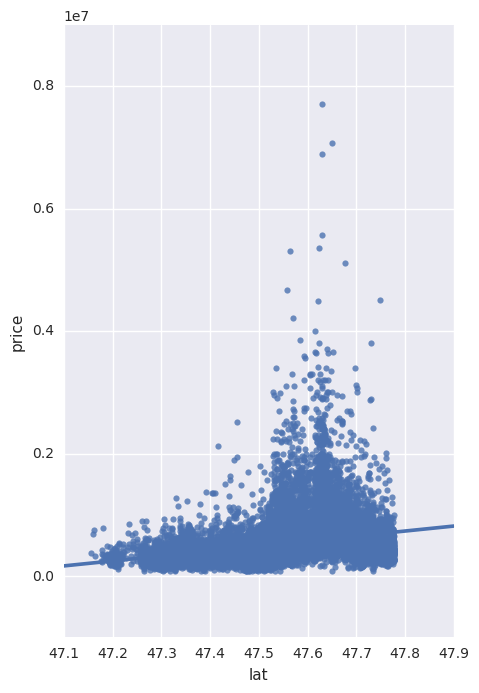

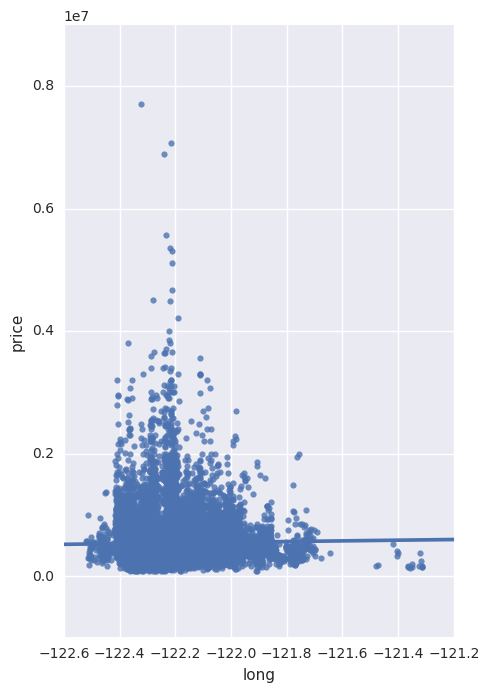

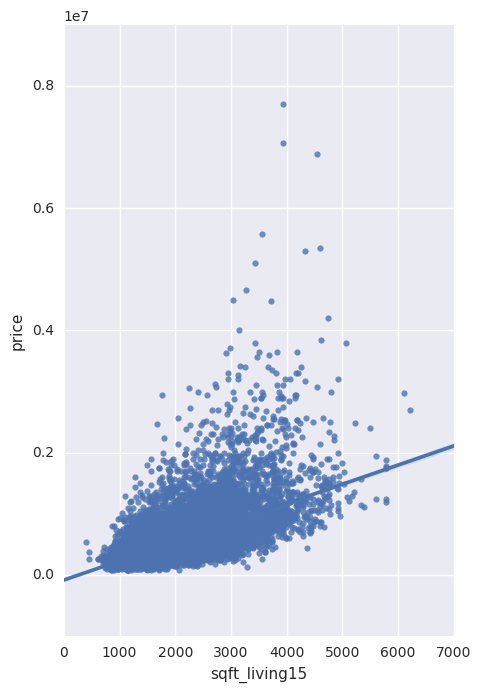

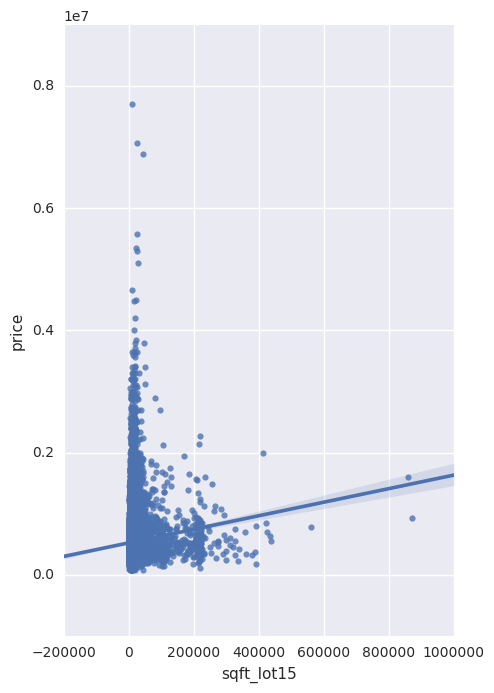

In [26]:
## pair plot

for feature in features:
    sns.pairplot(df, x_vars=feature, y_vars=df.columns[2], size=7, aspect=0.7, kind='reg')
    plt.show()

For the feature "bedrooms", value more than 30 seems to be an outlier. 

### Outliers Detection

In [27]:
def detect_outliers_z_score(df, feature, threshold=3):
    data = df[feature]
    z_score = scipy.stats.zscore(data)
    return df[np.abs(z_score) > threshold] # the threshold for Z-score is usually 3

detect_outliers_z_score(df, "bedrooms", 5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
4096,1997200215,20140507T000000,599999.00,9,4.50,3830,6988,2.50,0,0,...,7,2450,1380,1938,0,98103,47.69,-122.34,1460,6291
4235,2902200015,20150106T000000,700000.00,9,3.00,3680,4400,2.00,0,0,...,7,2830,850,1908,0,98102,47.64,-122.32,1960,2450
6079,9822700190,20140808T000000,1280000.00,9,4.50,3650,5000,2.00,0,0,...,8,2530,1120,1915,2010,98105,47.66,-122.29,2510,5000
8546,424049043,20140811T000000,450000.00,9,7.50,4050,6504,2.00,0,0,...,7,4050,0,1996,0,98144,47.59,-122.30,1448,3866
8757,1773100755,20140821T000000,520000.00,11,3.00,3000,4960,2.00,0,0,...,7,2400,600,1918,1999,98106,47.56,-122.36,1420,4960
13314,627300145,20140814T000000,1148000.00,10,5.25,4590,10920,1.00,0,2,...,9,2500,2090,2008,0,98004,47.59,-122.11,2730,10400
15161,5566100170,20141029T000000,650000.00,10,2.00,3610,11914,2.00,0,0,...,7,3010,600,1958,0,98006,47.57,-122.17,2040,11914
15870,2402100895,20140625T000000,640000.00,33,1.75,1620,6000,1.00,0,0,...,7,1040,580,1947,0,98103,47.69,-122.33,1330,4700
16844,8823900290,20150317T000000,1400000.00,9,4.00,4620,5508,2.50,0,0,...,11,3870,750,1915,0,98105,47.67,-122.31,2710,4320
18443,8823901445,20150313T000000,934000.00,9,3.00,2820,4480,2.00,0,0,...,7,1880,940,1918,0,98105,47.67,-122.31,2460,4400


In [28]:
# By interquartile range (IQR)
# IQR is the difference between the 75th and 25th percentile of the data.

def detect_outliers_IQR(df, feature, times_IQR=1.5):
    data = df[feature]
    quartile_1, quartile_3 = np.percentile(data, [25, 75])
    IQR = scipy.stats.iqr(data)
    lower = quartile_1 - (IQR * times_IQR)
    upper = quartile_3 + (IQR * times_IQR)
    return df[(data > upper) | (data < lower)] 

detect_outliers_IQR(df, "bedrooms", 3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1660,9126101740,20141204T000000,490000.00,8,5.00,2800,2580,2.00,0,0,...,8,1880,920,1997,0,98122,47.61,-122.30,1800,2580
4035,685000115,20141007T000000,2150000.00,8,6.00,4340,9415,2.00,0,0,...,8,4340,0,1967,0,98004,47.63,-122.20,2050,9100
4067,7226500100,20150219T000000,373000.00,8,3.00,2850,12714,1.00,0,0,...,7,2850,0,1959,0,98055,47.49,-122.20,1480,4942
4096,1997200215,20140507T000000,599999.00,9,4.50,3830,6988,2.50,0,0,...,7,2450,1380,1938,0,98103,47.69,-122.34,1460,6291
4235,2902200015,20150106T000000,700000.00,9,3.00,3680,4400,2.00,0,0,...,7,2830,850,1908,0,98102,47.64,-122.32,1960,2450
6079,9822700190,20140808T000000,1280000.00,9,4.50,3650,5000,2.00,0,0,...,8,2530,1120,1915,2010,98105,47.66,-122.29,2510,5000
6174,1873400020,20140703T000000,340000.00,8,2.75,2790,6695,1.00,0,0,...,7,1470,1320,1977,0,98133,47.76,-122.33,1760,7624
8546,424049043,20140811T000000,450000.00,9,7.50,4050,6504,2.00,0,0,...,7,4050,0,1996,0,98144,47.59,-122.30,1448,3866
8757,1773100755,20140821T000000,520000.00,11,3.00,3000,4960,2.00,0,0,...,7,2400,600,1918,1999,98106,47.56,-122.36,1420,4960
9077,6746700615,20150318T000000,700000.00,8,2.50,2280,3000,1.50,0,0,...,7,1210,1070,1911,0,98105,47.67,-122.32,1610,3000


### Features Selection

In [29]:
ranks = {}

def MinMax_scores(scores, order=1):
    MinMax = MinMaxScaler()
    return np.round(MinMax.fit_transform(order * scores[:, np.newaxis]), 2)

In [30]:
rand_lasso = RandomizedLasso()
rand_lasso.fit(df[features], price)
ranks["rand_lasso"] = MinMax_scores(rand_lasso.scores_)

RandomizedLasso(alpha='aic', eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=500, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

In [31]:
ranks["rand_lasso"]

array([[ 1.  ],
       [ 1.  ],
       [ 0.55],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ],
       [ 0.81],
       [ 0.  ],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ],
       [ 1.  ]])

In [32]:
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(df[features], price)
rfe = RFE(lin_reg, n_features_to_select=1, verbose=3)
rfe.fit(df[features], price)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True),
  n_features_to_select=1, step=1, verbose=3)

In [33]:
rfe.ranking_

array([ 8,  6, 12, 18, 10,  1,  5,  7,  3, 13, 14,  9, 16, 11,  2,  4, 15,
       17])

In [34]:
ranks["RFE"] = MinMax_scores(rfe.ranking_, order=-1)
ranks["RFE"] 

array([[ 0.59],
       [ 0.71],
       [ 0.35],
       [ 0.  ],
       [ 0.47],
       [ 1.  ],
       [ 0.76],
       [ 0.65],
       [ 0.88],
       [ 0.29],
       [ 0.24],
       [ 0.53],
       [ 0.12],
       [ 0.41],
       [ 0.94],
       [ 0.82],
       [ 0.18],
       [ 0.06]])

In [35]:
lin_reg.coef_

array([ -35766.54144367,   41144.27853243,      89.07965674,
             0.12859787,    6689.55011509,  582960.45842343,
         52870.94238432,   26385.64913859,   95890.44515148,
            92.1484322 ,      61.02084783,   -2620.2232113 ,
            19.81258371,    -582.41986564,  602748.22644858,
       -214729.82825328,      21.68140046,      -0.38264185])

In [36]:
# use Linear Regression
ranks["lin_reg"] = MinMax_scores(lin_reg.coef_)
ranks["lin_reg"]

array([[ 0.22],
       [ 0.31],
       [ 0.26],
       [ 0.26],
       [ 0.27],
       [ 0.98],
       [ 0.33],
       [ 0.29],
       [ 0.38],
       [ 0.26],
       [ 0.26],
       [ 0.26],
       [ 0.26],
       [ 0.26],
       [ 1.  ],
       [ 0.  ],
       [ 0.26],
       [ 0.26]])

In [37]:
ridge = Ridge(alpha=7)
ridge.fit(df[features], price)
ranks["ridge"] = MinMax_scores(ridge.coef_)
ranks["ridge"]

Ridge(alpha=7, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

array([[ 0.22],
       [ 0.31],
       [ 0.26],
       [ 0.26],
       [ 0.27],
       [ 0.95],
       [ 0.33],
       [ 0.29],
       [ 0.38],
       [ 0.26],
       [ 0.26],
       [ 0.26],
       [ 0.26],
       [ 0.26],
       [ 1.  ],
       [ 0.  ],
       [ 0.26],
       [ 0.26]])

In [38]:
lasso = Lasso(alpha=0.05)
lasso.fit(df[features], price)
ranks["lasso"] = MinMax_scores(lasso.coef_)
ranks["lasso"]

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

array([[ 0.22],
       [ 0.31],
       [ 0.26],
       [ 0.26],
       [ 0.27],
       [ 0.98],
       [ 0.33],
       [ 0.29],
       [ 0.38],
       [ 0.26],
       [ 0.26],
       [ 0.26],
       [ 0.26],
       [ 0.26],
       [ 1.  ],
       [ 0.  ],
       [ 0.26],
       [ 0.26]])

In [39]:
rand_forest_reg = RandomForestRegressor()
rand_forest_reg.fit(df[features], price)
ranks["rand_forest_reg"] = MinMax_scores(rand_forest_reg.feature_importances_)
ranks["rand_forest_reg"]


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

array([[ 0.  ],
       [ 0.01],
       [ 0.74],
       [ 0.04],
       [ 0.  ],
       [ 0.08],
       [ 0.02],
       [ 0.  ],
       [ 1.  ],
       [ 0.07],
       [ 0.01],
       [ 0.08],
       [ 0.  ],
       [ 0.03],
       [ 0.46],
       [ 0.2 ],
       [ 0.09],
       [ 0.04]])

In [40]:
extra_tree_reg = ExtraTreesRegressor()
extra_tree_reg.fit(df[features], price)
extra_tree_reg.feature_importances_
ranks["extra_tree_reg"] = MinMax_scores(extra_tree_reg.feature_importances_)
ranks["extra_tree_reg"]

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

array([ 0.0078146 ,  0.01884967,  0.2237901 ,  0.01187924,  0.0068231 ,
        0.04231904,  0.03792552,  0.00942175,  0.26381568,  0.04715713,
        0.01245613,  0.03716425,  0.0056557 ,  0.02420432,  0.13059938,
        0.04300928,  0.06584074,  0.01127436])

array([[ 0.01],
       [ 0.05],
       [ 0.84],
       [ 0.02],
       [ 0.  ],
       [ 0.14],
       [ 0.12],
       [ 0.01],
       [ 1.  ],
       [ 0.16],
       [ 0.03],
       [ 0.12],
       [ 0.  ],
       [ 0.07],
       [ 0.48],
       [ 0.14],
       [ 0.23],
       [ 0.02]])

In [41]:
sorted_keys =sorted(ranks.keys())
df_scores = [pd.DataFrame(ranks[key]) for key in sorted_keys]
ranks_np = np.concatenate(df_scores, axis=1)
ranks_df = pd.DataFrame(ranks_np, index=features, columns=sorted_keys)
ranks_df

,RFE,extra_tree_reg,lasso,lin_reg,rand_forest_reg,rand_lasso,ridge
bedrooms,0.59,0.01,0.22,0.22,0.00,1.00,0.22
bathrooms,0.71,0.05,0.31,0.31,0.01,1.00,0.31
sqft_living,0.35,0.84,0.26,0.26,0.74,0.55,0.26
sqft_lot,0.00,0.02,0.26,0.26,0.04,1.00,0.26
floors,0.47,0.00,0.27,0.27,0.00,1.00,0.27
waterfront,1.00,0.14,0.98,0.98,0.08,1.00,0.95
view,0.76,0.12,0.33,0.33,0.02,1.00,0.33
condition,0.65,0.01,0.29,0.29,0.00,1.00,0.29
grade,0.88,1.00,0.38,0.38,1.00,1.00,0.38
sqft_above,0.29,0.16,0.26,0.26,0.07,0.81,0.26


In [42]:
ranks_df["mean"] = ranks_df.mean(axis=1)
ranks_df

,RFE,extra_tree_reg,lasso,lin_reg,rand_forest_reg,rand_lasso,ridge,mean
bedrooms,0.59,0.01,0.22,0.22,0.00,1.00,0.22,0.32
bathrooms,0.71,0.05,0.31,0.31,0.01,1.00,0.31,0.39
sqft_living,0.35,0.84,0.26,0.26,0.74,0.55,0.26,0.47
sqft_lot,0.00,0.02,0.26,0.26,0.04,1.00,0.26,0.26
floors,0.47,0.00,0.27,0.27,0.00,1.00,0.27,0.33
waterfront,1.00,0.14,0.98,0.98,0.08,1.00,0.95,0.73
view,0.76,0.12,0.33,0.33,0.02,1.00,0.33,0.41
condition,0.65,0.01,0.29,0.29,0.00,1.00,0.29,0.36
grade,0.88,1.00,0.38,0.38,1.00,1.00,0.38,0.72
sqft_above,0.29,0.16,0.26,0.26,0.07,0.81,0.26,0.30


In [43]:
ranks_df_sorted = ranks_df.sort_values(by="mean", ascending=False)
ranks_df_sorted

,RFE,extra_tree_reg,lasso,lin_reg,rand_forest_reg,rand_lasso,ridge,mean
lat,0.94,0.48,1.00,1.00,0.46,1.00,1.00,0.84
waterfront,1.00,0.14,0.98,0.98,0.08,1.00,0.95,0.73
grade,0.88,1.00,0.38,0.38,1.00,1.00,0.38,0.72
sqft_living,0.35,0.84,0.26,0.26,0.74,0.55,0.26,0.47
view,0.76,0.12,0.33,0.33,0.02,1.00,0.33,0.41
bathrooms,0.71,0.05,0.31,0.31,0.01,1.00,0.31,0.39
condition,0.65,0.01,0.29,0.29,0.00,1.00,0.29,0.36
yr_built,0.53,0.12,0.26,0.26,0.08,1.00,0.26,0.36
zipcode,0.41,0.07,0.26,0.26,0.03,1.00,0.26,0.33
sqft_living15,0.18,0.23,0.26,0.26,0.09,1.00,0.26,0.33


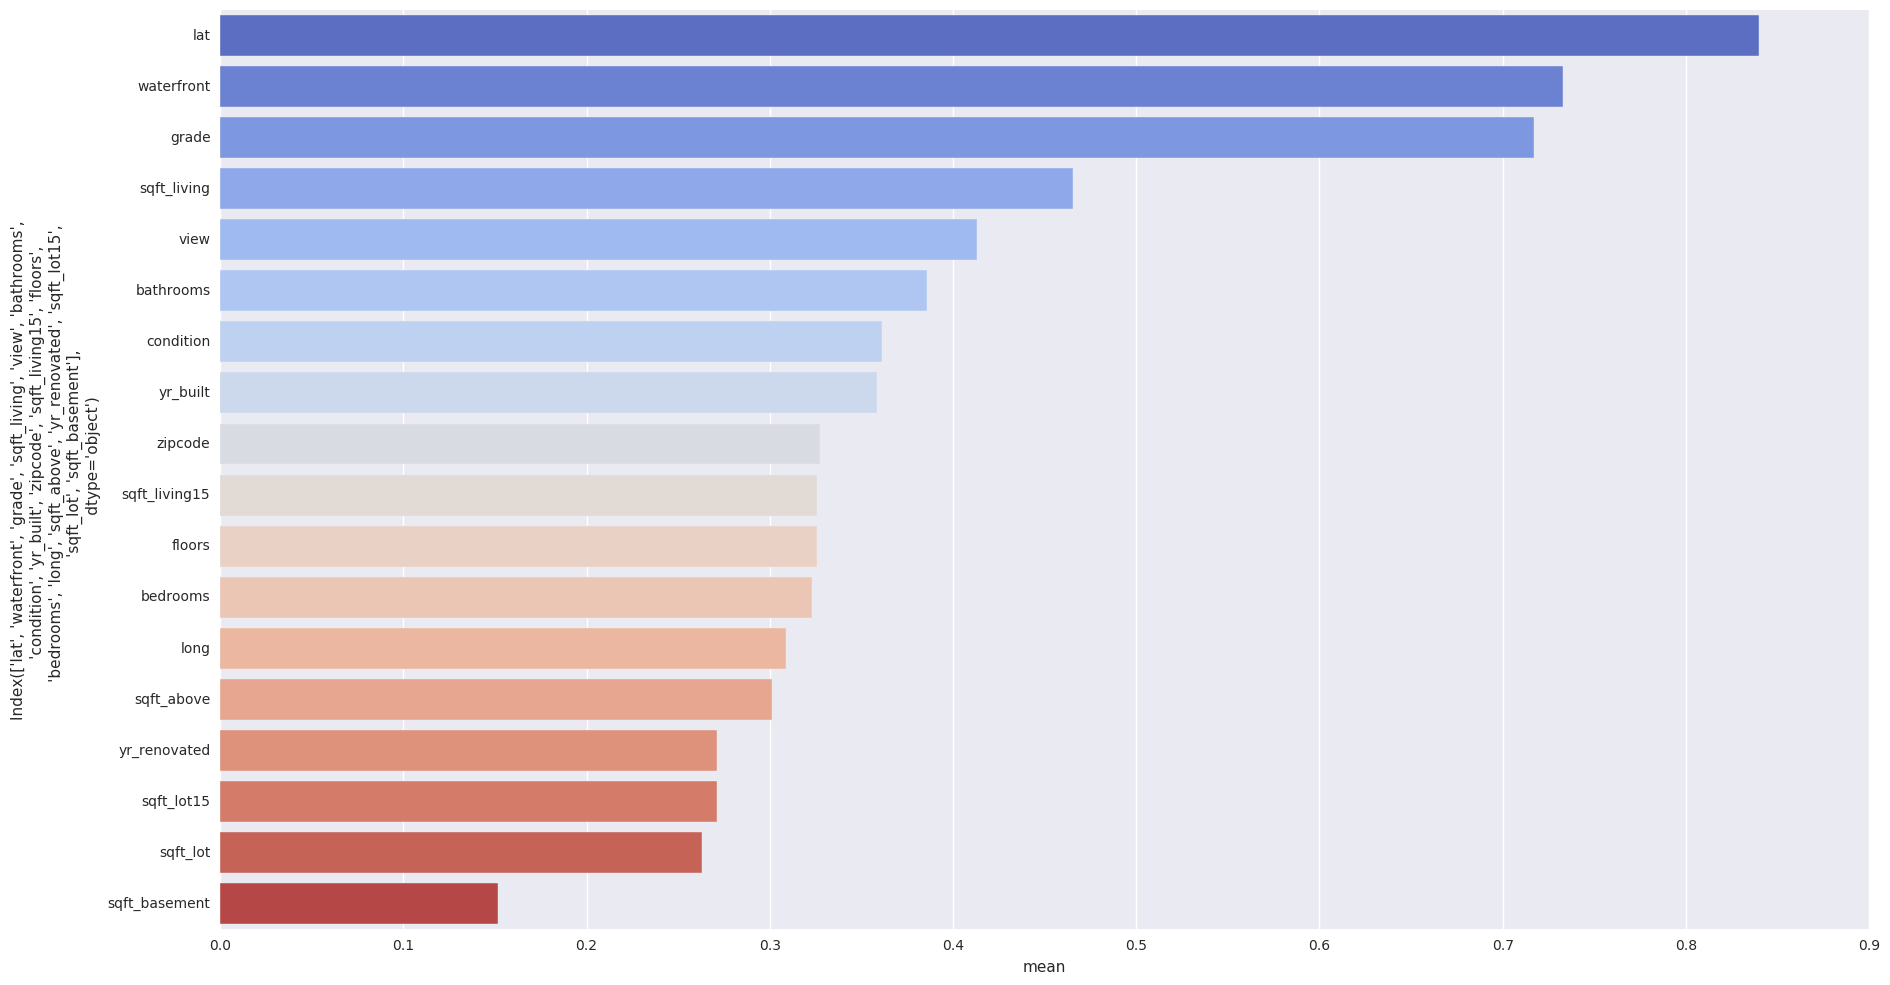

In [44]:
sns.factorplot(x="mean", y=ranks_df_sorted.index, data=ranks_df_sorted, kind="bar", 
               size=10, aspect=1.9, palette='coolwarm')
plt.show()

### Compare models for predicting house price

In [45]:
models = [
    ('LinReg', LinearRegression()),
    ('ridge', Ridge()),
    ('lasso', Lasso()),
    ('knnReg', KNeighborsRegressor(n_neighbors=20)),
    ("BayesianRidge", BayesianRidge()),
    ("ElasticNet", ElasticNet()),
    ("RandomForestRegressor", RandomForestRegressor()),
    ("ExtraTreesRegressor", ExtraTreesRegressor()),
    ("GradientBoostingRegressor", GradientBoostingRegressor())
        ]

In [46]:
model_scores = {}
for name, model in models:
    scores = cross_val_score(model, df[features], price, cv=10, scoring='r2')
    model_scores[name] = scores.mean()
print(sorted(model_scores.items(), key=lambda t: t[-1], reverse=True))        

[('RandomForestRegressor', 0.8658762099527173), ('GradientBoostingRegressor', 0.86152188887726278), ('ExtraTreesRegressor', 0.85883363095565213), ('ridge', 0.69519237548869672), ('BayesianRidge', 0.69518920906650217), ('LinReg', 0.69518752477304802), ('lasso', 0.69518728161998011), ('ElasticNet', 0.61373452126930206), ('knnReg', 0.49855288305944317)]


In [47]:
model_scores_log_price = {}
for name, model in models:
    scores = cross_val_score(model, df[features], np.log(price), cv=10, scoring='r2')
    model_scores_log_price[name] = scores.mean()
print(sorted(model_scores_log_price.items(), key=lambda t: t[-1], reverse=True))        

[('ExtraTreesRegressor', 0.8795733240300706), ('GradientBoostingRegressor', 0.87673939001494783), ('RandomForestRegressor', 0.87620802069857751), ('LinReg', 0.76626833607758038), ('BayesianRidge', 0.76626659017235621), ('ridge', 0.76626420426705932), ('ElasticNet', 0.52972807171467029), ('knnReg', 0.52883448419132706), ('lasso', 0.52699687411054363)]


### Parameters tuning using grid search

In [48]:
# Choose ExtraTreesRegressor for parameters tuning by using GridSearchCV
param_grid = dict(n_estimators=[5, 10, 20, 30], max_features=[10, 15, "auto", "sqrt"], random_state=[4])
Extra_Trees_Reg = ExtraTreesRegressor()
grid = GridSearchCV(Extra_Trees_Reg, param_grid=param_grid, cv=10, scoring="r2")
grid.fit(df[features], np.log(price))

grid.best_score_
grid.best_params_

GridSearchCV(cv=10, error_score='raise',
       estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [5, 10, 20, 30], 'random_state': [4], 'max_features': [10, 15, 'auto', 'sqrt']},
       pre_dispatch='2*n_jobs', refit=True, scoring='r2', verbose=0)

0.8896554229509339

{'max_features': 'auto', 'n_estimators': 30, 'random_state': 4}

In [49]:
# by RandomizedSearchCV
rand_grid = RandomizedSearchCV(Extra_Trees_Reg, param_distributions=param_grid, cv=10, scoring="r2")
rand_grid.fit(df[features], np.log(price))

rand_grid.best_score_
rand_grid.best_params_

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [5, 10, 20, 30], 'random_state': [4], 'max_features': [10, 15, 'auto', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          scoring='r2', verbose=0)

0.8893997315245451

{'max_features': 15, 'n_estimators': 30, 'random_state': 4}

### Use the best parameters for predictions

In [50]:
## 70% for training, 20% for validation, 10 % for testing 
X_train, X_others, y_train, y_others = train_test_split(df[features], price, test_size=0.3)
X_validation, X_test, y_validation, y_test = train_test_split(X_others, y_others, test_size=0.3)

## use the best parameters for predictions
Extra_Trees_Reg = ExtraTreesRegressor(n_estimators=30, random_state=4) # auto is the default for 'max_features'
Extra_Trees_Reg.fit(X_train, np.log(y_train))

y_pred_val = Extra_Trees_Reg.predict(X_validation)
metrics.r2_score(np.log(y_validation), y_pred_val)

y_pred_test = Extra_Trees_Reg.predict(X_test)
metrics.r2_score(np.log(y_test), y_pred_test)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=30, n_jobs=1, oob_score=False, random_state=4,
          verbose=0, warm_start=False)

0.88117369468566842

0.87528161543887706

#### References:

https://www.kaggle.com/arthurtok/feature-ranking-rfe-random-forest-linear-models
    
https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python    

http://colingorrie.github.io/outlier-detection.html

https://www.datacamp.com/community/blog/scikit-learn-cheat-sheet   

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection

http://scikit-learn.org/stable/modules/model_evaluation.html